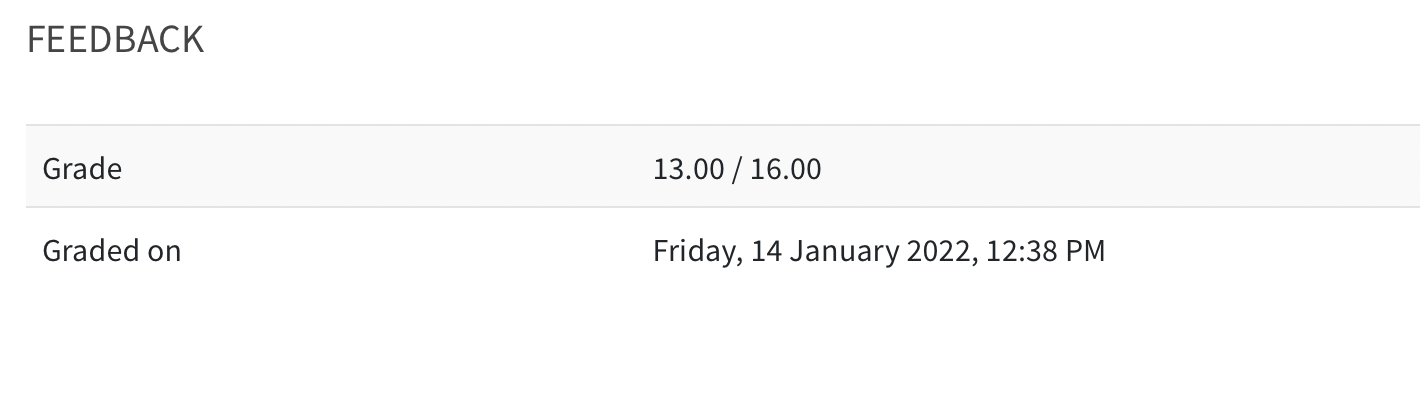

# 1 Author

- Jiahao Meng

# 2 Problem formulation

#### What we have:
- 4 Zip files:
    - 417 Potter recordings (either hum or whistle);
    - 417 StarWars recordings (either hum or whistle);
    - divided by songs label to the correct folder;
    - Files names should follow the rules.
    
- MLEnd_2021_Starter_kit.ipynb:
    - Provide essential skills.

#### What we want:
- Build a Machine Learning pipeline to classify whether a recording is Harry or StarWars.


# 3 Machine Learning pipeline

Audio files --> Transformation --> Training --> Optimisation & Validation -->Testing --> Song Lable: Harry/StarWars?

# 4 Transform stage

- Audio files --> Feature Extraction --> Outlier Detection --> Normalisation --> Reduction --> Features

## 4.1 Feature Extraction
- Get any potential useful features at once, then store them in the dataframe to avoid time waste:
    - Essential features: power, pitch_mean, pitch_std, voiced_fr;
    - Additional features: rms, chroma_stft, spec_cent, spec_bw, rolloff, zcr, mfc.
    
> Applications of Audio Processing:
https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

## 4.2 Outlier Detection
- Not everyone follows straightforward instructions; there is no reason to believe every sample.
> Reference: https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/

## 4.3 Data Transformation: Normalisation
- Data are transformed to make the resulting mining process more efficient, and the patterns found may be easier to understand;
- The measurement unit used in an attribute can affect data analysis. In normalization, attributes are scaled to fall within a smaller, speciﬁed range, such that all attributes have equal weight in the analysis.

### 4.3.1  Min-Max Normalisation
- Suitable for: All features have the same scale, but it does not handle outliers well.

### 4.3.2 Z-Score scaling
- Suitable for: Handles outliers but does not produce normalized data with the same scale.

## 4.4 Data Reduction: PCA
- Complex analysis may take a very long time to run on a complete data set;
- PCA (Principal Component Analysis) is mainly used to reduce the size of the feature space while retaining as much of the information as possible. Here, all the features were transformed into 2 features using PCA.

# 5 Modelling
Based on the requirement and PCA, we can use followed classification models:
- Support Vector Machines;
- k-Nearest Neighbors;
- Naive Bayes;
- Decision Trees Classifier;
- Extra Trees Classifier;
- Random Forest Classifier.

# 6 Methodology
> The best guide and ultimate judge is always the **experiment**. https://stackoverflow.com/questions/61441974/recursive-feature-selection-may-not-yield-higher-performance/61444056#61444056

## 6.1 Training 
- Unfortunately, we cannot theoretically determine which model matches which database can have better performance, so we need to verify each combination as much as possible.

- To evaluate models effectively, we need to split out datasets into three parts:
    1. Training dataset (60%)
    2. Validation dataset (20%)
    3. Testing dataset (20%)

## 6.2 Optimisation & Validation
- Once we find the 2 best transformation methods for different models based the accuracy, we can use them to find the best hyperparameter(s) by GridSearchCV:
    - GridSearchCV offers a convenient way to choose hyperparameters based on cross-validation.
    
- Select the best classifier based on the accuracy score from GridSearchCV
    

## 6.3 Testing
- **Test and assess** the best model with the best parameters:
    - Use confusion_matrix and classification_report from sklearn.metrics;
    - Pay more attention to accuracy instead of f1 score because of the balanced datasets and split randomly.
    
### 6.3.1 Comparison
- Control variable:
    - Assess the same model with the same parameters in the initial dataset;
    - Compare the confusion matrix.

# 7 Dataset

- Datasets we will create after Transforming:
    1. Initial dataset
    2. MinMax dataset
    3. Z-Score dataset
    4. PCA (Initial) dataset
    5. PCA (MinMax) dataset
    6. PCA (Z-score) dataset

## 7.1 Data
- Row dataset:
    - The names of each file should be:
    - [participant_ID]\_hum_1_[song label];
    - [participant_ID]\_hum_2_[song label];
    - [participant_ID]\_whistle_1_[song label];
    - [participant_ID]\_whistle_2_[song label].

- However, **Not everyone follows** straightforward instructions.
- Hence, we need to **verify and correct** the data.

# 8 Results
Carry out your experiments here, explain your results.

In [1]:
import os, sys, re, pickle, glob
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import sklearn

In [2]:
sample_path = 'ML_data/*/*.*'
files = glob.glob(sample_path)
print ('We have {0} recordings.'.format(len(files)))

We have 834 recordings.


In [3]:
# create a dataframe to store the essential attribute(s)
col = ['file_id','song']
MLENDHW_df = pd.DataFrame(np.NaN, index = np.arange(0,len(files),1), columns = col)
MLENDHW_df['file_id'] = files

# assign song labels based on different folder names
for i in range(len(MLENDHW_df)):
    MLENDHW_df.iloc[i, MLENDHW_df.columns.get_loc('song')] = MLENDHW_df.iloc[i]['file_id'].split('/')[1]
MLENDHW_df = MLENDHW_df.set_index('file_id')
MLENDHW_df['song'].value_counts()
MLENDHW_df.head()

song
file_id                                     
ML_data/Potter/S54_hum_2_Potter.wav   Potter
ML_data/Potter/S135_hum_2_Potter.wav  Potter
ML_data/Potter/S36_hum_1_Potter.wav   Potter
ML_data/Potter/S157_hum_1_Potter.wav  Potter
ML_data/Potter/S169_hum_1_Potter.wav  Potter

In [4]:
# verify the labels
MLENDHW_df['song'].value_counts()

StarWars    417
Potter      417
Name: song, dtype: int64

- Based on the Mini-project description File, the model need to predicts the song label either Harry or StarWars.
- Therefore, replace the 'Potter' with 'Harry'

In [5]:
MLENDHW_df['song'][MLENDHW_df['song'] == 'Potter'] = 'Harry'
MLENDHW_df['song'].value_counts()

StarWars    417
Harry       417
Name: song, dtype: int64

## 7.2 Transform
### 7.2.1 Feature Extraction

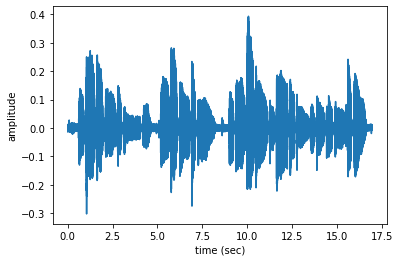

song    Harry
Name: ML_data/Potter/S54_hum_2_Potter.wav, dtype: object

In [6]:
# thanks for the starter kit
n=0
sr = 44100 
x, sr = librosa.load(files[n],sr=sr)
t = np.arange(len(x))/sr
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))
MLENDHW_df.iloc[n]

In [7]:
def getPitch(x,sr,winLen=0.02):
    #winLen = 0.02 
    p = winLen*sr
    frame_length = int(2**int(p-1).bit_length())
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=sr,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

def get_features(files,labels_file):
    X,y =[],[]
    for file in tqdm(files):
        yi = labels_file.loc[file]['song']
        
                                              
        x, sr = librosa.load(file, sr=44100)
        f0, voiced_flag = getPitch(x,sr,winLen=0.02)
        
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
        
        rms = librosa.feature.rms(x)
        chroma_stft = librosa.feature.chroma_stft(x, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(x, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(x, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(x, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(x)
        mfcc = librosa.feature.mfcc(x, sr=sr)
        xi = [power, pitch_mean, pitch_std, voiced_fr, 
              np.mean(rms), np.mean(chroma_stft), np.mean(spec_cent), 
              np.mean(spec_bw), np.mean(rolloff), np.mean(zcr)]
        for e in mfcc:
            xi.append(np.mean(e))
                                      
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

In [8]:
X,y = get_features(files, labels_file = MLENDHW_df)

100%|██████████| 834/834 [17:49<00:00,  1.28s/it]


In [9]:
# Store all features in the dataframe to avoid time waste
col = ['power', 'pitch_mean', 'pitch_std', 'voiced_fr',
       'rms','chroma_stft','spec_cent', 'spec_bw','rolloff', 'zcr', 
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 
      'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 
      'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15',
      'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20']
features = pd.DataFrame(X, index = np.arange(0,len(X),1), columns = col)
features['song'] = y
features

power  pitch_mean  pitch_std  voiced_fr       rms  chroma_stft  \
0    0.003052  190.417149  50.864984   0.761286  0.044459     0.385606   
1    0.001044  163.599373  36.483218   0.837442  0.025696     0.369473   
2    0.001093  175.055281  30.935956   0.781818  0.026082     0.326766   
3    0.001100  328.123816  63.809047   0.873926  0.026810     0.240389   
4    0.000301  287.373148  43.199989   0.708982  0.013336     0.321363   
..        ...         ...        ...        ...       ...          ...   
829  0.002493  231.432478  57.359071   0.774689  0.042084     0.331719   
830  0.020877  405.208867  33.260235   0.774981  0.093458     0.195716   
831  0.003582  186.740685  38.114051   0.848694  0.048981     0.339757   
832  0.001153  378.193942  79.055452   0.588897  0.022066     0.366672   
833  0.000176  353.311610  61.045785   0.834261  0.010163     0.226655   

       spec_cent      spec_bw      rolloff       zcr  ...    mfcc_12  \
0    1675.204038  3065.165898  2849.997495  0.019332  ...   9.028441   
1    1659.010167  3177.825718  2996.482908  0.028275  ...  -4.836066   
2    2132.550131  2873.497796  3873.793126  0.064123  ...  -8.495154   
3    1932.344222  3112.003116  3602.106920  0.042381  ... -19.055544   
4    2257.836962  4246.474464  4508.408028  0.025941  ...  -4.388329   
..           ...          ...          ...       ...  ...        ...   
829  1860.893273  3112.447059  3460.292804  0.027326  ...  12.112650   
830  2775.112649  3009.801995  4982.298666  0.078699  ...   0.227998   
831  1643.143014  2804.135389  3355.111202  0.027606  ...  -4.798544   
832  2719.979938  4198.495497  5460.747678  0.043782  ...  -0.873236   
833  3822.862791  4796.683804  6938.418857  0.096396  ...  -4.323521   

       mfcc_13    mfcc_14    mfcc_15    mfcc_16   mfcc_17    mfcc_18  \
0     6.223410  -8.596852  -2.297908  -4.239172 -4.558042 -10.959394   
1    -3.286189  -2.981515  -8.571086  -9.878811 -4.143748  -2.277181   
2    -7.217812 -22.594255 -23.461632  -8.656265 -4.932810 -14.356619   
3   -11.107067  -3.579709 -14.142939 -15.667487 -2.266381  -2.766565   
4    -3.727430  -0.236710  -8.469546  -4.573374 -1.898902  -8.878784   
..         ...        ...        ...        ...       ...        ...   
829   0.932452 -19.251062 -13.094616  -0.769233 -4.398502  -4.590833   
830   7.313174   3.584602  -2.560793  -3.585562 -0.964728   1.899497   
831  -7.256934 -11.297347 -12.600592  -8.131459 -3.863375  -2.929201   
832   6.155696  13.969900   9.597282   3.716655  6.163775   3.814223   
833 -13.337029 -12.709845   4.332189   6.701385  1.994825   2.457891   

       mfcc_19    mfcc_20      song  
0    -5.215251  -6.671832     Harry  
1    -8.926064 -14.712740     Harry  
2   -16.773382  -8.207474     Harry  
3   -10.478158  -2.765479     Harry  
4    -4.827067  -1.811098     Harry  
..         ...        ...       ...  
829  -5.222107 -12.472143  StarWars  
830   4.021675   4.246054  StarWars  
831  -9.988239 -18.541967  StarWars  
832   6.353235   8.273810  StarWars  
833   7.015620  14.084597  StarWars  

[834 rows x 31 columns]

In [10]:
# Avoid contamination of raw data.
X = np.array(features[col]).copy()
y = np.array(features['song']).copy()

### 7.2.2 Outlier Detection
- To better understand the result of outlier detection, we can compare the attributes via PCA before and after outlier detection. (more details on 7.2.4 Data Reduction: PCA)

In [11]:
# Define a function which can visualize PCA and return the PCA data.
def visual_PCA(data, output_data = False, visual = False):
    from sklearn.decomposition import PCA
    numComponents = 2
    pca = PCA(n_components=numComponents)
    pca.fit(data)
    pca_data = pca.transform(data)
    print('Variance of each component:',
                   pca.explained_variance_ratio_)
    
    # Display a scatterplot of the two principal components
    if visual:
        X_pca_df = pd.DataFrame(data = pca_data, columns = ['pc1', 'pc2'])
        y_pca_df = pd.DataFrame(y, columns = ['song'])
        pca_df = pd.concat((X_pca_df, y_pca_df), axis=1)

        fig = plt.figure(figsize = (7,7))
        ax = fig.add_subplot(1,1,1)
        ax.scatter(pca_df['pc1'][pca_df['song'] == 'Harry'], 
                   pca_df['pc2'][pca_df['song'] == 'Harry'], 
                   color = '#005CAF', label = 'Harry')
        
        ax.scatter(pca_df['pc1'][pca_df['song'] == 'StarWars'], 
                   pca_df['pc2'][pca_df['song'] == 'StarWars'],
                   color = '#00AA90', label = 'StarWars')

        ax.set_xlabel('First Principal Component ', fontsize = 13) 
        ax.set_ylabel('Second Principal Component ', fontsize = 13) 
        ax.set_title('PCA', fontsize = 17)
        ax.legend()
        plt.show()
    
    if output_data:
        return (pca_data)

Variance of each component: [0.95897757 0.0274288 ]


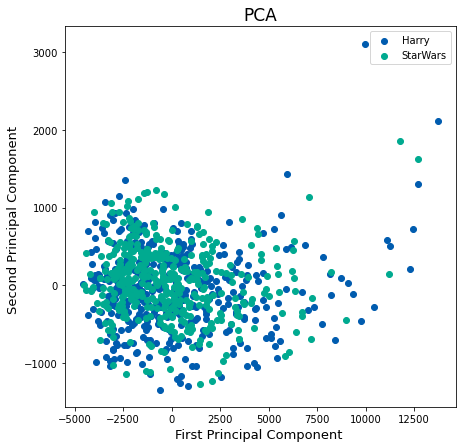

In [12]:
visual_PCA(X, visual = True)

In [13]:
# define a outlier detection, which can display the outlier randomly 
# for double checked manually / automatically, and return the inliers.

def outlier_detect(data_X, data_y, n_neighbors, output_data = False):
    from sklearn.neighbors import LocalOutlierFactor
    from sklearn.metrics import mean_absolute_error

    # identify outliers in the entire dataset
    lof = LocalOutlierFactor(n_neighbors)
    yhat = lof.fit_predict(data_X)
    
    # extract the outliers(-1)
    outlier = (yhat == -1)
    temp = []
    for i in range(len(outlier)):
        if outlier[i]:
            temp.append(files[i])
    print ('There are {0} outliers which is {1:.2f}% of the entire dataset.'
           .format(len(temp), len(temp)/len(X)*100))        
    print ('Play one of the outliers randomly:')
    ran = np.random.randint(0, len(temp))
    display(ipd.Audio(temp[ran]))
    
    # return the inliers
    X_in = data_X[yhat != -1]
    y_in = data_y[yhat != -1]
    if output_data:
        return (X_in, y_in)
    
    # If we do not want to check them manually, we can refer to the MAE
    # evaluate SVM model performance with outliers removed using local outlier factor:

    # X_train, y_train = X_train[mask, :], y_train[mask]   
    # # summarize the shape of the updated training dataset
    # print(X_train.shape, y_train.shape)
    # # fit the model
    # model = SVC(C=1)
    # model.fit(X_train, y_train)
    # # evaluate the model
    # yhat = model.predict(X_test)
    # # evaluate predictions
    # mae = mean_absolute_error(y_test, yhat)
    # print('MAE: %.3f' % mae)

There are 19 outliers which is 2.28% of the entire dataset.
Play one of the outliers randomly:


Variance of each component: [0.95254082 0.03184373]


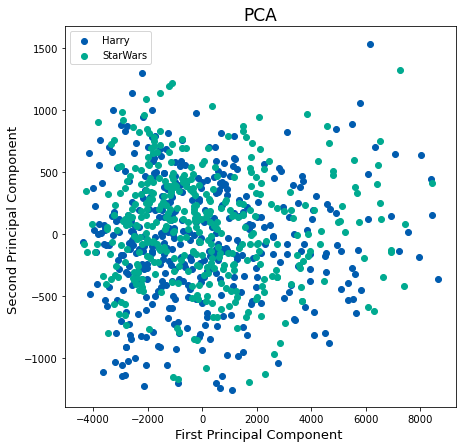

In [14]:
# Return the inliers
X_in, y_in = outlier_detect(X, y, n_neighbors = 50, output_data = True)

# Visualize the results of outlier eliminated, do not return the PCA data
visual_PCA(X_in, visual = True, output_data = False)

## 7.2.3 Data Transformation: Normalisation
### 7.2.3.1 Min-Max Normalisation

In [15]:
from sklearn.preprocessing import minmax_scale
X_minmax = minmax_scale(X_in)

### 7.2.3.2 Z-Score scaling

In [16]:
from scipy.stats import zscore
X_zscore = zscore(X_in)

## 7.2.4 Data Reduction: PCA

Variance of each component: [0.95254082 0.03184373]


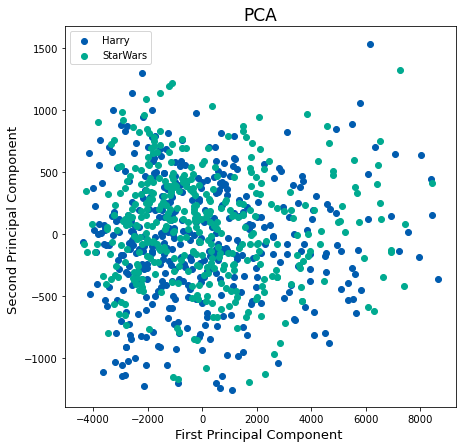

In [17]:
# return PCA to X_pca
X_pca = visual_PCA(X_in, visual = True, output_data = True)

Variance of each component: [0.25591028 0.15445454]


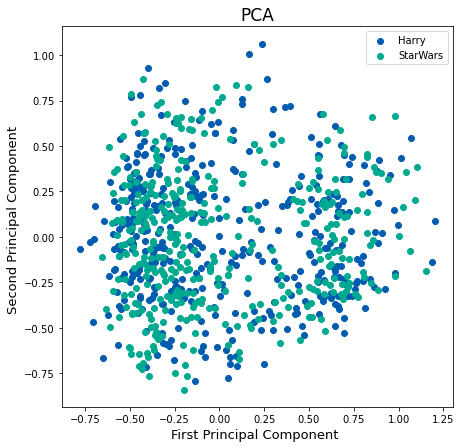

In [18]:
X_pca_minmax = visual_PCA(X_minmax, visual = True, output_data = True)

Variance of each component: [0.20949818 0.14701339]


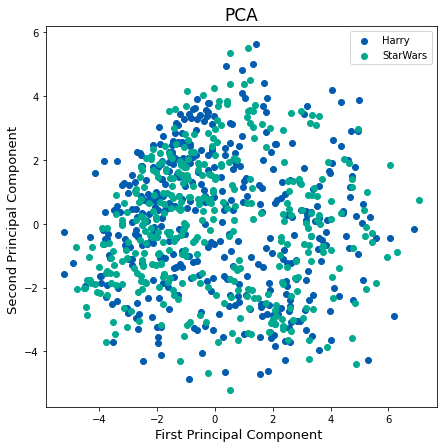

In [19]:
X_pca_zscore = visual_PCA(X_zscore, visual = True, output_data = True)

## 7.3 Methodology
### 7.3.1 Training

In [20]:
# Split the dataset
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_in,y_in,test_size=0.2, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size=0.25, random_state = 0)


X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax = train_test_split(X_minmax,y_in,test_size=0.2, random_state = 0)
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(X_train_minmax,y_train_minmax,test_size=0.25, random_state = 0)


X_train_zscore, X_val_zscore, y_train_zscore, y_val_zscore = train_test_split(X_zscore,y_in,test_size=0.2, random_state = 0)
X_train_zscore, X_test_zscore, y_train_zscore, y_test_zscore = train_test_split(X_train_zscore,y_train_zscore,test_size=0.25, random_state = 0)

X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(X_pca,y_in,test_size=0.2, random_state = 0)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_train_pca,y_train_pca,test_size=0.25, random_state = 0)

X_train_pca_minmax, X_val_pca_minmax, y_train_pca_minmax, y_val_pca_minmax = train_test_split(X_pca_minmax,y_in,test_size=0.2, random_state = 0)
X_train_pca_minmax, X_test_pca_minmax, y_train_pca_minmax, y_test_pca_minmax = train_test_split(X_train_pca_minmax,y_train_pca_minmax,test_size=0.25, random_state = 0)

X_train_pca_zscore, X_val_pca_zscore, y_train_pca_zscore, y_val_pca_zscore = train_test_split(X_pca_zscore,y_in,test_size=0.2, random_state = 0)
X_train_pca_zscore, X_test_pca_zscore, y_train_pca_zscore, y_test_pca_zscore = train_test_split(X_train_pca_zscore,y_train_pca_zscore,test_size=0.25, random_state = 0)

In [21]:
# Define a training function for efficiency

dataset = [[X_train, X_val, y_train, y_val, 'Initial'],
           [X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax, 'MinMax'],
           [X_train_zscore, X_val_zscore, y_train_zscore, y_val_zscore, 'Z-Score'],
           [X_train_pca, X_val_pca, y_train_pca, y_val_pca, 'PCA'],
           [X_train_pca_minmax, X_val_pca_minmax, y_train_pca_minmax, y_val_pca_minmax,'PCA (MinMax)'],
           [X_train_pca_zscore, X_val_pca_zscore, y_train_pca_zscore, y_val_pca_zscore,'PCA (Z-score)']]

def model_train (model_name):
    for i in dataset:
        model_name.fit(i[0],i[2])
        print('Training accuracy of {0} with {1} data is: {2:.3f}'.format(model_name, i[4], model_name.score(i[0], i[2])))
        print('Validation accuracy of {0} with {1} data is: {2:.3f}'.format(model_name, i[4], model_name.score(i[1], i[3])))
        print('******')

In [22]:
from sklearn.svm import SVC
svc = SVC(C=1, random_state=0)
model_train(svc)

Training accuracy of SVC(C=1, random_state=0) with Initial data is: 0.554
Validation accuracy of SVC(C=1, random_state=0) with Initial data is: 0.546
******
Training accuracy of SVC(C=1, random_state=0) with MinMax data is: 0.722
Validation accuracy of SVC(C=1, random_state=0) with MinMax data is: 0.607
******
Training accuracy of SVC(C=1, random_state=0) with Z-Score data is: 0.793
Validation accuracy of SVC(C=1, random_state=0) with Z-Score data is: 0.577
******
Training accuracy of SVC(C=1, random_state=0) with PCA data is: 0.558
Validation accuracy of SVC(C=1, random_state=0) with PCA data is: 0.546
******
Training accuracy of SVC(C=1, random_state=0) with PCA (MinMax) data is: 0.546
Validation accuracy of SVC(C=1, random_state=0) with PCA (MinMax) data is: 0.528
******
Training accuracy of SVC(C=1, random_state=0) with PCA (Z-score) data is: 0.558
Validation accuracy of SVC(C=1, random_state=0) with PCA (Z-score) data is: 0.497
******


In [23]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
model_train(knn)

Training accuracy of KNeighborsClassifier() with Initial data is: 0.706
Validation accuracy of KNeighborsClassifier() with Initial data is: 0.589
******
Training accuracy of KNeighborsClassifier() with MinMax data is: 0.687
Validation accuracy of KNeighborsClassifier() with MinMax data is: 0.613
******
Training accuracy of KNeighborsClassifier() with Z-Score data is: 0.661
Validation accuracy of KNeighborsClassifier() with Z-Score data is: 0.564
******
Training accuracy of KNeighborsClassifier() with PCA data is: 0.667
Validation accuracy of KNeighborsClassifier() with PCA data is: 0.534
******
Training accuracy of KNeighborsClassifier() with PCA (MinMax) data is: 0.693
Validation accuracy of KNeighborsClassifier() with PCA (MinMax) data is: 0.552
******
Training accuracy of KNeighborsClassifier() with PCA (Z-score) data is: 0.642
Validation accuracy of KNeighborsClassifier() with PCA (Z-score) data is: 0.528
******


In [24]:
from sklearn.naive_bayes import GaussianNB
gnb_A = GaussianNB()
model_train(gnb_A)

Training accuracy of GaussianNB() with Initial data is: 0.616
Validation accuracy of GaussianNB() with Initial data is: 0.528
******
Training accuracy of GaussianNB() with MinMax data is: 0.601
Validation accuracy of GaussianNB() with MinMax data is: 0.485
******
Training accuracy of GaussianNB() with Z-Score data is: 0.601
Validation accuracy of GaussianNB() with Z-Score data is: 0.485
******
Training accuracy of GaussianNB() with PCA data is: 0.575
Validation accuracy of GaussianNB() with PCA data is: 0.552
******
Training accuracy of GaussianNB() with PCA (MinMax) data is: 0.513
Validation accuracy of GaussianNB() with PCA (MinMax) data is: 0.571
******
Training accuracy of GaussianNB() with PCA (Z-score) data is: 0.515
Validation accuracy of GaussianNB() with PCA (Z-score) data is: 0.552
******


In [25]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
model_train(dtc)

Training accuracy of DecisionTreeClassifier(random_state=0) with Initial data is: 1.000
Validation accuracy of DecisionTreeClassifier(random_state=0) with Initial data is: 0.503
******
Training accuracy of DecisionTreeClassifier(random_state=0) with MinMax data is: 1.000
Validation accuracy of DecisionTreeClassifier(random_state=0) with MinMax data is: 0.503
******
Training accuracy of DecisionTreeClassifier(random_state=0) with Z-Score data is: 1.000
Validation accuracy of DecisionTreeClassifier(random_state=0) with Z-Score data is: 0.503
******
Training accuracy of DecisionTreeClassifier(random_state=0) with PCA data is: 1.000
Validation accuracy of DecisionTreeClassifier(random_state=0) with PCA data is: 0.509
******
Training accuracy of DecisionTreeClassifier(random_state=0) with PCA (MinMax) data is: 1.000
Validation accuracy of DecisionTreeClassifier(random_state=0) with PCA (MinMax) data is: 0.485
******
Training accuracy of DecisionTreeClassifier(random_state=0) with PCA (Z-sco

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(random_state=0)
model_train(etc)

Training accuracy of ExtraTreesClassifier(random_state=0) with Initial data is: 1.000
Validation accuracy of ExtraTreesClassifier(random_state=0) with Initial data is: 0.626
******
Training accuracy of ExtraTreesClassifier(random_state=0) with MinMax data is: 1.000
Validation accuracy of ExtraTreesClassifier(random_state=0) with MinMax data is: 0.626
******
Training accuracy of ExtraTreesClassifier(random_state=0) with Z-Score data is: 1.000
Validation accuracy of ExtraTreesClassifier(random_state=0) with Z-Score data is: 0.626
******
Training accuracy of ExtraTreesClassifier(random_state=0) with PCA data is: 1.000
Validation accuracy of ExtraTreesClassifier(random_state=0) with PCA data is: 0.558
******
Training accuracy of ExtraTreesClassifier(random_state=0) with PCA (MinMax) data is: 1.000
Validation accuracy of ExtraTreesClassifier(random_state=0) with PCA (MinMax) data is: 0.577
******
Training accuracy of ExtraTreesClassifier(random_state=0) with PCA (Z-score) data is: 1.000
Val

In [27]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
model_train(rfc)

Training accuracy of RandomForestClassifier(random_state=0) with Initial data is: 1.000
Validation accuracy of RandomForestClassifier(random_state=0) with Initial data is: 0.626
******
Training accuracy of RandomForestClassifier(random_state=0) with MinMax data is: 1.000
Validation accuracy of RandomForestClassifier(random_state=0) with MinMax data is: 0.626
******
Training accuracy of RandomForestClassifier(random_state=0) with Z-Score data is: 1.000
Validation accuracy of RandomForestClassifier(random_state=0) with Z-Score data is: 0.626
******
Training accuracy of RandomForestClassifier(random_state=0) with PCA data is: 1.000
Validation accuracy of RandomForestClassifier(random_state=0) with PCA data is: 0.540
******
Training accuracy of RandomForestClassifier(random_state=0) with PCA (MinMax) data is: 1.000
Validation accuracy of RandomForestClassifier(random_state=0) with PCA (MinMax) data is: 0.534
******
Training accuracy of RandomForestClassifier(random_state=0) with PCA (Z-sco

### 7.3.2 Optimisation & Validation
- Based on the Initial dataset, MinMax dataset and Z-score dataset.

In [28]:
dataset = [[X_train, X_val, y_train, y_val, 'Initial'],
           [X_train_minmax, X_val_minmax, y_train_minmax, y_val_minmax, 'MinMax'],
           [X_train_zscore, X_val_zscore, y_train_zscore, y_val_zscore, 'Z-Score']]

In [29]:
from sklearn.model_selection import GridSearchCV
def find_parameters (classifier, parameters, random = False):
    if random:
        cf = classifier(random_state=0)
    else:
        cf = classifier()
    cf_cv = GridSearchCV(cf, parameters)
    for i in dataset:
        cf_cv.fit(i[0],i[2])
        print('Best hyperparameter setting: {0}.'.format(cf_cv.best_estimator_))
        print('Average accuracy across folds with {1} data: {0}.'.format(cf_cv.best_score_, i[4]))
        print('Validation dataset accuracy with {1} data: {0}.'.format(cf_cv.score(i[1], i[3]),i[4]))
        print('******')

In [30]:
find_parameters(SVC, {'C': np.arange(1,100,1)}, random = True)

Best hyperparameter setting: SVC(C=63, random_state=0).
Average accuracy across folds with Initial data: 0.5765832106038291.
Validation dataset accuracy with Initial data: 0.5644171779141104.
******
Best hyperparameter setting: SVC(C=1, random_state=0).
Average accuracy across folds with MinMax data: 0.5991163475699558.
Validation dataset accuracy with MinMax data: 0.6073619631901841.
******
Best hyperparameter setting: SVC(C=1, random_state=0).
Average accuracy across folds with Z-Score data: 0.5909110035766884.
Validation dataset accuracy with Z-Score data: 0.5766871165644172.
******


In [31]:
# Cross validation for KNN
find_parameters(KNeighborsClassifier, {'n_neighbors': np.arange(1,100,1)})

Best hyperparameter setting: KNeighborsClassifier(n_neighbors=89).
Average accuracy across folds with Initial data: 0.558405217757206.
Validation dataset accuracy with Initial data: 0.5460122699386503.
******
Best hyperparameter setting: KNeighborsClassifier(n_neighbors=39).
Average accuracy across folds with MinMax data: 0.5949505575426046.
Validation dataset accuracy with MinMax data: 0.5276073619631901.
******
Best hyperparameter setting: KNeighborsClassifier(n_neighbors=40).
Average accuracy across folds with Z-Score data: 0.5929728592467916.
Validation dataset accuracy with Z-Score data: 0.5276073619631901.
******


In [32]:
# Cross validation for DecisionTree
find_parameters(DecisionTreeClassifier, {'min_samples_leaf': np.arange(1,100,1), 'min_samples_split':np.arange(0.01,1,0.01)}, random = True)

Best hyperparameter setting: DecisionTreeClassifier(min_samples_leaf=33,
                       min_samples_split=0.18000000000000002, random_state=0).
Average accuracy across folds with Initial data: 0.5992846623185357.
Validation dataset accuracy with Initial data: 0.5214723926380368.
******
Best hyperparameter setting: DecisionTreeClassifier(min_samples_leaf=33,
                       min_samples_split=0.18000000000000002, random_state=0).
Average accuracy across folds with MinMax data: 0.5992846623185357.
Validation dataset accuracy with MinMax data: 0.5214723926380368.
******
Best hyperparameter setting: DecisionTreeClassifier(min_samples_leaf=33,
                       min_samples_split=0.18000000000000002, random_state=0).
Average accuracy across folds with Z-Score data: 0.5992846623185357.
Validation dataset accuracy with Z-Score data: 0.5214723926380368.
******


In [33]:
# Cross validation for ExtraTrees
find_parameters(ExtraTreesClassifier, {'n_estimators': np.arange(1,100,1)}, random = True)

Best hyperparameter setting: ExtraTreesClassifier(n_estimators=31, random_state=0).
Average accuracy across folds with Initial data: 0.6032190195665894.
Validation dataset accuracy with Initial data: 0.6257668711656442.
******
Best hyperparameter setting: ExtraTreesClassifier(n_estimators=31, random_state=0).
Average accuracy across folds with MinMax data: 0.6032190195665894.
Validation dataset accuracy with MinMax data: 0.6257668711656442.
******
Best hyperparameter setting: ExtraTreesClassifier(n_estimators=31, random_state=0).
Average accuracy across folds with Z-Score data: 0.6032190195665894.
Validation dataset accuracy with Z-Score data: 0.6257668711656442.
******


In [34]:
# Cross validation for RandomForest
find_parameters(RandomForestClassifier, {'n_estimators': np.arange(1,200,5)}, random = True)

Best hyperparameter setting: RandomForestClassifier(n_estimators=76, random_state=0).
Average accuracy across folds with Initial data: 0.6175257731958763.
Validation dataset accuracy with Initial data: 0.6012269938650306.
******
Best hyperparameter setting: RandomForestClassifier(n_estimators=76, random_state=0).
Average accuracy across folds with MinMax data: 0.6175257731958763.
Validation dataset accuracy with MinMax data: 0.6012269938650306.
******
Best hyperparameter setting: RandomForestClassifier(n_estimators=76, random_state=0).
Average accuracy across folds with Z-Score data: 0.619566589522407.
Validation dataset accuracy with Z-Score data: 0.6134969325153374.
******


- As we can see, **Extra Trees Classifier** has the best performance.

In [35]:
etc = ExtraTreesClassifier(n_estimators = 31, random_state = 0)
etc.fit (X_train, y_train)
yv_etc = etc.predict(X_val)
print('Training accuracy of {0} with initial data is: {1:.3f}'.format(etc, etc.score(X_train, y_train)))
print('Validation accuracy of {0} with initial data is: {1:.3f}'.format(etc, etc.score(X_val, y_val)))

Training accuracy of ExtraTreesClassifier(n_estimators=31, random_state=0) with initial data is: 1.000
Validation accuracy of ExtraTreesClassifier(n_estimators=31, random_state=0) with initial data is: 0.626


### 7.3.3 Testing

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Heatmap for confusion matrix
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

In [37]:
etc = ExtraTreesClassifier(n_estimators = 31, random_state = 0)
etc.fit (X_train, y_train)
yv_etc = etc.predict(X_test)

print('Training accuracy of {0} with zscore data is: {1:.3f}'.format(etc, etc.score(X_train, y_train)))
print('Testing accuracy of {0} with zscore data is: {1:.3f}'.format(etc, etc.score(X_test, y_test)))
print('******')

Training accuracy of ExtraTreesClassifier(n_estimators=31, random_state=0) with zscore data is: 1.000
Testing accuracy of ExtraTreesClassifier(n_estimators=31, random_state=0) with zscore data is: 0.607
******


              precision    recall  f1-score     support
Harry          0.579545  0.653846  0.614458   78.000000
StarWars       0.640000  0.564706  0.600000   85.000000
accuracy       0.607362  0.607362  0.607362    0.607362
macro avg      0.609773  0.609276  0.607229  163.000000
weighted avg   0.611071  0.607362  0.606918  163.000000


/Users/jiahao/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=['StarWars', 'Harry'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


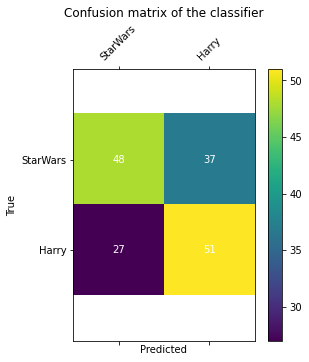

In [38]:
report = classification_report(yv_etc, y_test_minmax, output_dict=True)
report = pd.DataFrame(report).transpose()
print (report)
confusion_matrix_heatmap(yv_etc, y_test_zscore)

# 8 Results

- Now, we get a classifier that can classify whether a record is Harry or StarWars by:
    - Trained by all features from librosa;
    - Eliminated the outliers;
    - Compared the different models trained by different transformation datasets;
    - Find the best hyperparameters via cross-validation.

# 9 Conclusions
- The best classifier is Extra Trees Classifier, trained by n_estimators=31 and initial dataset.
- In general, the testing accuracy of the classifier is 61%.
- When it indicates a recording is a Harry, the probability of being correct is 57%.
- When it indicates a recording is a StarWars, the probability of being correct is 64%.
- However, it is not good enough based on these accuracies. We need to do more things to improve it in the advanced part:
    - Features Selection
    - Voting Classifier